# Chap03 - Word2Vec

## 3.1 추론 기반 기법과 신경망

단어를 벡터로 표현하는 방법 중 성공적인 기법은 **통계 기반 기법**과 **추론 기반 기법**이며 단어의 의미를 얻는 방식은 서로 다르지만 배경에는 모두 분포 가설이 있다.

아래에서는 통계 기반 기법의 문제점과 추론 기반 기법의 이점을 거시적 관점에서 설명하고 word2vec의 전처리를 위해 신경망으로 **단어**를 처리하는 예시를 보여준다.

### 3.1.1 통계 기반 기법의 문제점

통계 기반 기법에서는 단어의 동시 발생 행렬을 만들고 그 행렬에 SVD를 적용해서 밀집 벡터를 얻었는데 실제로 다루는 말뭉치의 어휘 수는 어마어마하기 때문에 대규모 말뭉치를 다룰 때 문제가 발생한다.

거대 행렬에 SVD를 적용하게 되면 SVD의 시간 복잡도는 O(n<sup>3</sup>)이므로 슈퍼컴퓨터로도 처리할 수 없는 연산을 해야 한다. 또한 말뭉치 전체의 통계를 이용해 1회의 처리로 단어의 분산 표현을 얻으므로 병렬 작업도 어렵다.

반면 추론 기반 기법 즉, 신경망을 이용하는 경우 미니배치로 학습하는 것이 일반적으로 소량의 학습 샘플에 대해 반복하여 가중치를 갱신하므로 여러 머신과 여러 GPU를 이용한 병렬 계산이 가능하여 학습 속도를 높일 수 있다.

### 3.1.2 추론 기반 기법 개요

추론기반 기법에서는 아래 그림처럼 주변 단어가 주어졌을 때 "?"에 무슨 단어가 들어가는지를  추측하며 이러한 추론 문제를 반복해서 풀면서 단어의 출현 패턴을 학습한다.

![](./deep_learning_2_images/inference.png)

말뭉치를 사용해 모델이 올바른 추측을 할 수 있도록 학습시키고 학습의 결과로 단어의 분산 표현을 얻는다.

통계 기반 기법처럼 '단어의 의미는 주변 단어에 의해 형성된다'는 분포가설에 기초하며 두 기법 모두 분포 가설에 근거하는 '단어의 동시발생 가능성'을 얼마나 잘 모델링하는지가 중요하다.

![](./deep_learning_2_images/inference02.png)



### 3.1.3 신경망에서의 단어 처리

신경망의 입력층에서 뉴런의 수를 **고정**하기 위해 단어를 **고정 길이 벡터**로 변환한다. 대표적인 기법으로 **원핫 벡터**를 사용 할 수 있다.

| 단어(텍스트) | 단어 ID | one-hot vector        |
| ------------ | ------- | --------------------- |
| you          | 0       | [1, 0, 0, 0, 0, 0, 0] |
| goodbye      | 2       | [0, 0, 1, 0, 0, 0, 0] |


<img src="./deep_learning_2_images/one-hot.png" height="65%" width="65%" />

아래 그림의 신경망은 완전연결계층이므로 각각의 노드가 이웃 층의 모든 노드와 화살표로 연결되어 있다. 각 화살표에는 가중치가 존재하고 입력층 뉴런과의 가중합이 은닉층 뉴런이 된다. 편향을 고려하지 않은 완전연결계층은 **행렬 곱**으로 수행할 수 있다.

![](./deep_learning_2_images/nn.png)

In [1]:
import numpy as np

c = np.array([[1, 0, 0, 0, 0, 0, 0]])  # 입력 (one-hot)
W = np.random.randn(7, 3)  # 가중치 (랜덤한 값), Word vector
h = np.matmul(c, W)  # 은닉층 노드
print(h)

[[ 0.90775468  0.27731673 -1.12302947]]


c는 원핫 표현으로 단어 ID에 해당하는 원소만 1이고 그 외에는 0인 벡터이므로 c와 W의 행렬 곱은 아래 그림 처럼 가중치의 행벡터 하나를 뽑아낸 것과 같다.

![](./deep_learning_2_images/matmul.png)

가중치로부터 행벡터를 뽑아내기 위해 행렬 곱을 연산하는 건 비효율적이므로 다음장에서 개선 할 예정이다.

In [2]:
import sys
sys.path.append('..')
import numpy as np
from common.layers import MatMul

c = np.array([[1, 0, 0, 0, 0, 0, 0]])
W = np.random.randn(7, 3)
layer = MatMul(W)
h = layer.forward(c)
print(h)

[[-1.01778412  0.00479286 -1.9354091 ]]


## 3.2 단순한 Word2Vec

### 3.2.1 CBOW 모델의 추론 처리

**CBOW** 모델은 주변단어로부터 중앙단어를 추측하는 용도의 신경망으로 맥락을 원핫 표현으로 변환하여 입력한다.

입력층이 2개 있고 은닉층을 거쳐 출력층에 도달하는 형태로 두 입력층에서 은닉층으로의 변환은 똑같은 완전연결계층이 처리하고 은닉층에서 출력층 뉴런으로의 변환은 다른 완전연결계층이 처리한다. 맥락으로 고려할 단어의 수에 n에 따라 입력층의 개수는 n개가 된다.

입력층의 완전연결계층에서 변환된 값은 입력층의 개수에 따라 전체를 평균하여 은닉층으로 전달한다. 출력층의 뉴런은 각각 단어 하나에 대응하며 이 점수에 소프트맥스 함수를 적용해서 확률을 얻을 수 있다.

<img src="./deep_learning_2_images/cbow.png" height="65%" width="65%" />

입력층에서 은닉층으로의 변환은 완전 연결계층에 의해서 이뤄지는데 이 때 가중치 W<sub>in</sub>의 각 행과 W<sub>out</sub>의 각 열이 단어의 분산 표현이 된다.

은닉층의 뉴런 수를 입력층의 뉴런 수보다 적게 하는게 핵심으로 이렇게 해야 은닉층에는 단어 예측에 필요한 정보를 간결하게 담게 되어 밀집벡터 표현을 얻을 수 있다.

<img src="./deep_learning_2_images/word_vec.png" height="65%" width="65%" />

In [3]:
# CBOW모델의 추론 처리 구현
# chap03/cbow_predict.py
import sys
sys.path.append('..')
import numpy as np
from common.layers import MatMul

# 샘플 맥락 데이터
c0 = np.array([[1, 0, 0, 0, 0, 0, 0]])
c1 = np.array([[0, 0, 1, 0, 0, 0, 0]])

# 가중치 초기화
W_in = np.random.randn(7, 3)
W_out = np.random.randn(3, 7)

# 계층 생성
in_layer0 = MatMul(W_in)
in_layer1 = MatMul(W_in)
out_layer = MatMul(W_out)

# 순전파
h0 = in_layer0.forward(c0)
h1 = in_layer1.forward(c1)
h = 0.5 * (h0 + h1)  # average
s = out_layer.forward(h)  # score

print(s)

[[ 0.46247418  1.08529398 -0.18936083 -0.58764069 -0.23109779 -0.17297715
  -0.89035869]]


### 3.2.2 CBOW 모델의 학습

CBOW 모델의 출력층에서 출력한 값에 소프트맥스 함수를 적용하면 맥락이 주어졌을 때 중앙에 어떤 단어가 출현하는지를 나타낸다. 손실 값은 크로스엔트로피 계층을 추가하여 확인 할 수 있다.

CBOW 모델의 학습에서는 올바른 예측을 할 수 있도록 가중치를 조정하고 그 결과로 가중치 W에 단어의 출현 패턴을 파악한 벡터가 학습된다. 그리고 학습 시 사용한 말뭉치에 따라 단어의 분산 표현도 달라진다.

<img src="./deep_learning_2_images/cbow02.png" height="65%" width="65%" />

### 3.2.3 Word2Vec의 가중치와 분산 표현

단어의 분산 표현은 인력 측과 출력 측 가중치에서 모두 확인 할 수 있으나 많은 연구에서는 입력층의 가중치만 이용한다. 다만 GloVe 기법에서는 두 가중치를 더했을 때 좋은 결과가 확인된다.

<img src="./deep_learning_2_images/word_vec.png" height="65%" width="65%" />

## 3.3 학습 데이터 준비

간단한 예로서 "You say goodbye and I say hello."라는 한 문장짜리 말뭉치를 이용한다.

### 3.3.1 맥락과 타깃

word2vec의 입력은 **맥락**이고 정답 레이블은 맥락에 둘러싸인 **타깃** 단어이다.

말뭉치에서 목표로 하는 단어와 주변 단어를 양끝 단어를 제외한 모든 단어에 대해 뽑아내서 맥락들을 신경망의 입력으로 쓰고 타깃을 정답 레이블로 사용한다.

![](./deep_learning_2_images/train_set.png)

In [4]:
import sys
sys.path.append('..')
from common.util import preprocess

text = 'You say goodbye and I say hello.'
corpus, word_to_id, id_to_word = preprocess(text)
print(corpus)

[0 1 2 3 4 1 5 6]


In [26]:
print(word_to_id)

{'you': 0, 'say': 1, 'goodbye': 2, 'and': 3, 'i': 4, 'hello': 5, '.': 6}


In [5]:
print(id_to_word)

{0: 'you', 1: 'say', 2: 'goodbye', 3: 'and', 4: 'i', 5: 'hello', 6: '.'}


In [6]:
# common/util.py
def create_contexts_target(corpus, window_size=1):
    '''맥락과 타깃 생성
    :param corpus: 말뭉치(단어 ID 목록)
    :param window_size: 윈도우 크기(윈도우 크기가 1이면 타깃 단어 좌우 한 단어씩이 맥락에 포함)
    :return: (맥락, 타겟)의 np.array
    '''
    target = corpus[window_size:-window_size]
    contexts = []
    
    for idx in range(window_size, len(corpus)-window_size):
        cs = []
        # wiondow_size만큼 타겟 단어 좌우 context 가져오기
        for t in range(-window_size, window_size+1):
            if t != 0:
                cs.append(corpus[idx + t])
        contexts.append(cs)
        
    return np.array(contexts), np.array(target)

In [7]:
import sys
sys.path.append('..')
from common.util import create_contexts_target

contexts, target = create_contexts_target(corpus, window_size=1)

In [8]:
print(contexts)

[[0 2]
 [1 3]
 [2 4]
 [3 1]
 [4 5]
 [1 6]]


In [9]:
print(target)

[1 2 3 4 1 5]


### 3.3.2 원핫 표현으로 변환

![](./deep_learning_2_images/one-hot2.png)

In [28]:
def convert_one_hot(corpus, vocab_size):
    '''원핫 표현으로 변환
    :param corpus: 단어 ID 목록(1차원 또는 2차원 넘파이 배열)
    :param vocab_size: 어휘 수
    :return: 원핫 표현(2차원 또는 3차원 넘파이 배열)
    '''
    N = corpus.shape[0]
    if corpus.ndim == 1:
        one_hot = np.zeros((N, vocab_size), dtype=np.int32)
        for idx, word_id in enumerate(corpus):
            one_hot[idx, word_id] = 1
            
    elif corpus.ndim == 2:
        C = corpus.shape[1]
        one_hot = np.zeros((N, C, vocab_size), dtype=np.int32)
        for idx_0, word_ids in enumerate(corpus):
            for idx_1, word_id in enumerate(word_ids):
                one_hot[idx_0, idx_1, word_id] = 1
                
    return one_hot

In [11]:
import sys
sys.path.append('..')
from common.util import preprocess, create_contexts_target, convert_one_hot

text = 'You say goodby and I say hello.'
corpus, word_to_id, id_to_word = preprocess(text)

contexts, target = create_contexts_target(corpus, window_size=1)

vocab_size = len(word_to_id)
target = convert_one_hot(target, vocab_size)
contexts = convert_one_hot(contexts, vocab_size)

In [12]:
print(target)

[[0 1 0 0 0 0 0]
 [0 0 1 0 0 0 0]
 [0 0 0 1 0 0 0]
 [0 0 0 0 1 0 0]
 [0 1 0 0 0 0 0]
 [0 0 0 0 0 1 0]]


In [13]:
print(contexts)

[[[1 0 0 0 0 0 0]
  [0 0 1 0 0 0 0]]

 [[0 1 0 0 0 0 0]
  [0 0 0 1 0 0 0]]

 [[0 0 1 0 0 0 0]
  [0 0 0 0 1 0 0]]

 [[0 0 0 1 0 0 0]
  [0 1 0 0 0 0 0]]

 [[0 0 0 0 1 0 0]
  [0 0 0 0 0 1 0]]

 [[0 1 0 0 0 0 0]
  [0 0 0 0 0 0 1]]]


## 3.4 CBOW 모델 구현

In [14]:
# chap03/simple_cbow.py
import sys
sys.path.append('..')
import numpy as np
from common.layers import MatMul, SoftmaxWithLoss


class SimpleCBOW:
    def __init__(self, vocab_size, hidden_size):
        V, H = vocab_size, hidden_size
        
        # 가중치 초기화
        W_in = 0.01 * np.random.randn(V, H).astype('f')
        W_out = 0.01 * np.random.randn(H, V).astype('f')
        
        # 레이어 생성
        self.in_layer0 = MatMul(W_in)
        self.in_layer1 = MatMul(W_in)
        self.out_layer = MatMul(W_out)
        self.loss_layer = SoftmaxWithLoss()
        
        # 모든 가중치와 기울기를 리스트에 모은다.
        layers = [self.in_layer0, self.in_layer1, self.out_layer]
        self.params, self.grads = [], []
        for layer in layers:
            self.params += layer.params
            self.grads += layer.grads
            
        # 인스턴스 변수에 단어의 분산 표현을 저장한다.
        self.word_vecs1 = W_in
        self.word_vecs2 = W_out.T
        
    def forward(self, contexts, target):
        h0 = self.in_layer0.forward(contexts[:, 0])
        h1 = self.in_layer1.forward(contexts[:, 1])
        h = (h0 + h1) * 0.5
        score = self.out_layer.forward(h)
        loss = self.loss_layer.forward(score, target)
        return loss
    
    def backward(self, dout=1):
        ds = self.loss_layer.backward(dout)
        da = self.out_layer.backward(ds)
        da *= 0.5
        self.in_layer1.backward(da)
        self.in_layer0.backward(da)
        return None

### 3.4.1 학습 코드 구현

In [15]:
# chap03/train.py
import sys
sys.path.append('..')
from common.trainer import Trainer
from common.optimizer import Adam
from common.util import preprocess, create_contexts_target, convert_one_hot


window_size = 1
hidden_size = 5
batch_size = 3
max_epoch = 1000

text = 'You say goodbye and I say hello.'
corpus, word_to_id, id_to_word = preprocess(text)

vocab_size = len(word_to_id)
# cbow 학습 데이터셋 생성
contexts, target = create_contexts_target(corpus, window_size)
# Input에 맞는 one-hot 표현 변환
target = convert_one_hot(target, vocab_size)
contexts = convert_one_hot(contexts, vocab_size)

# 모델 초기화
model = SimpleCBOW(vocab_size, hidden_size)
optimizer = Adam()
trainer = Trainer(model, optimizer)

In [16]:
# 학습
trainer.fit(contexts, target, max_epoch, batch_size)

| 에폭 1 |  반복 1 / 2 | 시간 0[s] | 손실 1.95
| 에폭 2 |  반복 1 / 2 | 시간 0[s] | 손실 1.95
| 에폭 3 |  반복 1 / 2 | 시간 0[s] | 손실 1.95
| 에폭 4 |  반복 1 / 2 | 시간 0[s] | 손실 1.95
| 에폭 5 |  반복 1 / 2 | 시간 0[s] | 손실 1.95
| 에폭 6 |  반복 1 / 2 | 시간 0[s] | 손실 1.95
| 에폭 7 |  반복 1 / 2 | 시간 0[s] | 손실 1.95
| 에폭 8 |  반복 1 / 2 | 시간 0[s] | 손실 1.95
| 에폭 9 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 10 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 11 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 12 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 13 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 14 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 15 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 16 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 17 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 18 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 19 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 20 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 21 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 22 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 23 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 24 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 25 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 26 |

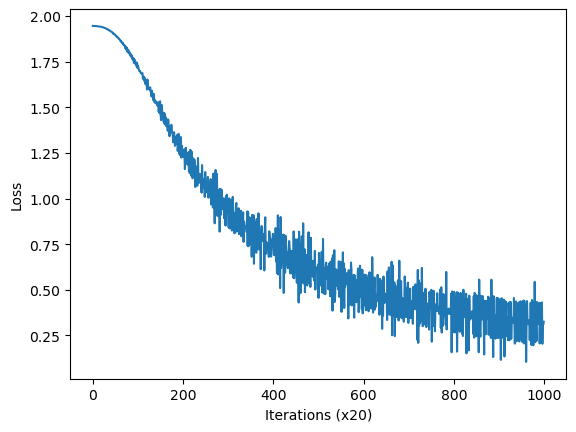

In [17]:
trainer.plot()

In [18]:
# Word Embedding 살펴보기
word_vecs1 = model.word_vecs1
for word_id, word in id_to_word.items():
    print(word, word_vecs1[word_id])

you [-1.0051619  1.0099914 -1.0261976  1.0111172 -1.6942375]
say [ 1.1856345  -1.1629628   1.1878576  -1.1635056  -0.08471144]
goodbye [-1.0004709  1.0339816 -1.0061299  1.0231321  0.7418583]
and [ 0.8917206 -0.9040623  0.9063524 -0.8859006 -1.877679 ]
i [-1.0236764  1.0390028 -1.008127   1.0477098  0.7321237]
hello [-0.9879256   1.0034472  -0.9997535   0.98915136 -1.6956002 ]
. [ 1.1381099 -1.1344017  1.1211643 -1.1387876  1.5934951]


In [19]:
# Word Embedding 살펴보기
word_vecs2 = model.word_vecs2
for word_id, word in id_to_word.items():
    print(word, word_vecs2[word_id])

you [ 0.01828255  0.04751983 -0.03076292 -0.1586642   0.44222897]
say [-0.9508784   0.95299906 -0.9620398   0.9328947  -2.0965436 ]
goodbye [ 0.63430077 -0.6214284   0.62219816 -0.6618099  -1.2259127 ]
and [-0.73343587  0.76067585 -0.7339556   0.7297699   1.9066974 ]
i [ 0.63237053 -0.62613153  0.6298585  -0.67086643 -1.203516  ]
hello [ 0.8117224  -0.7934889   0.7921614  -0.81518173  1.9299198 ]
. [ 0.01247432  0.04137147 -0.02600597 -0.1531299   0.4404771 ]


## 3.5 Word2Vec 보충

### 3.5.1 CBOW 모델과 확률

- $P(A)$ : A가 발생할 확률


- $P(A|B)$ : **사후확률**, **사건**이 일어난 **후의 확률**을 의미
    - 'B가 주어졌을 때 A가 일어날 확률'
    
    
CBOW 모델은 맥락(contexts)을 주면 타깃 단어가 출현할 확률을 출력하는 것이다. 

![](./deep_learning_2_images/cbow04.png)

위의 그림처럼, $w_{t-1}$과 $w_{t+1}$이 일어난 후 $w_t$가 일어날 확률을 수식으로 나타내면 다음과 같다.


$$
P(w_t | w_{t-1}, w_{t+1})
$$

CBOW 모델의 손실 함수는 위 식에 음의 로그를 취하면된다.
$$
L = -\log{P(w_t | w_{t-1}, w_{t+1})}
$$

CBOW 모델의 학습을 통해 손실 함수의 값을 가능한 작게 만드는게 목표이고 이 때 가중치 매개변수가 얻고자 하는 단어의 분산표현이다.

### 3.5.2 skip-gram 모델

skip-gram 모델은 CBOW에서 다루는 맥락과 타깃을 역전시킨 모델이다.

중앙의 단어(타깃)으로부터 주변의 여러 단어(맥락)을 추측한다.

![](./deep_learning_2_images/skip-gram02.png)

아래 그림과 같이 skip-gram 모델의 입력층은 하나이고 출력층은 맥락의 수만큼 존재한다.

따라서 출력층에서는 개별적으로 손실을 구하고 개별 손실을 모두 더한 값을 최종 손실로 한다.

![](./deep_learning_2_images/skip-gram.png)


더 어려운 상황에서 단련하는 만큼 단어 분산 표현의 정밀도 면에서 skip-gram 모델의 결과가 CBOW 대비 더 좋은 경우가 많고 말뭉치가 커질수록 저빈도 단어나 유추 문제의 성능 면에서 더 뛰어나다.

학습 속도 면에서는 CBOW모델이 더 빠르다. skip-gram모들은 손실을 맥락(contexts)의 수만큼 구해야하므로 그 만큼 계산비용이 커진다.

In [25]:
# chap03/simple_skip_gram.py
import sys
sys.path.append('..')
import numpy as np
from common.layers import MatMul, SoftmaxWithLoss


class SimpleSkipGram:
    def __init__(self, vocab_size, hidden_size):
        V, H = vocab_size, hidden_size
        
        # 가중치 초기화
        W_in = 0.01 * np.random.randn(V, H).astype('f')
        W_out = 0.01 * np.random.randn(H, V).astype('f')
        
        # 레이어 생성
        self.in_layer = MatMul(W_in)
        self.out_layer = MatMul(W_out)
        self.loss_layer1 = SoftmaxWithLoss()
        self.loss_layer2 = SoftmaxWithLoss()
        
        # 모든 가중치와 기울기를 리스트에 모은다.
        layers = [self.in_layer, self.out_layer]
        self.params, self.grads = [], []
        for layer in layers:
            self.params += layer.params
            self.grads += layer.grads
            
        # 인스턴스 변수에 단어의 분산표현을 저장한다.
        self.word_vecs1 = W_in
        self.word_vecs2 = W_out.T
        
    def forward(self, contexts, target):
        h = self.in_layer.forward(target)
        s = self.out_layer.forward(h)
        l1 = self.loss_layer1.forward(s, contexts[:, 0])
        l2 = self.loss_layer2.forward(s, contexts[:, 1])
        loss = l1 + l2
        return loss
    
    def backward(self, dout=1):
        dl1 = self.loss_layer1.backward(dout)
        dl2 = self.loss_layer2.backward(dout)
        ds = dl1 + dl2
        dh = self.out_layer.backward(ds)
        self.in_layer.backward(dh)
        return None

In [29]:
# chap03/train.py
import sys
sys.path.append('..')
from common.trainer import Trainer
from common.optimizer import Adam
from common.util import preprocess, create_contexts_target, convert_one_hot


window_size = 1
hidden_size = 5
batch_size = 3
max_epoch = 1000

text = 'You say goodbye and I say hello.'
corpus, word_to_id, id_to_word = preprocess(text)

vocab_size = len(word_to_id)
# cbow 학습 데이터셋 생성
contexts, target = create_contexts_target(corpus, window_size)
# Input에 맞는 one-hot 표현 변환
target = convert_one_hot(target, vocab_size)
contexts = convert_one_hot(contexts, vocab_size)

# 모델 초기화
model = SimpleSkipGram(vocab_size, hidden_size)
optimizer = Adam()
trainer = Trainer(model, optimizer)

In [30]:
# 학습
trainer.fit(contexts, target, max_epoch, batch_size)

| 에폭 1 |  반복 1 / 2 | 시간 0[s] | 손실 3.89
| 에폭 2 |  반복 1 / 2 | 시간 0[s] | 손실 3.89
| 에폭 3 |  반복 1 / 2 | 시간 0[s] | 손실 3.89
| 에폭 4 |  반복 1 / 2 | 시간 0[s] | 손실 3.89
| 에폭 5 |  반복 1 / 2 | 시간 0[s] | 손실 3.89
| 에폭 6 |  반복 1 / 2 | 시간 0[s] | 손실 3.89
| 에폭 7 |  반복 1 / 2 | 시간 0[s] | 손실 3.89
| 에폭 8 |  반복 1 / 2 | 시간 0[s] | 손실 3.89
| 에폭 9 |  반복 1 / 2 | 시간 0[s] | 손실 3.89
| 에폭 10 |  반복 1 / 2 | 시간 0[s] | 손실 3.89
| 에폭 11 |  반복 1 / 2 | 시간 0[s] | 손실 3.89
| 에폭 12 |  반복 1 / 2 | 시간 0[s] | 손실 3.89
| 에폭 13 |  반복 1 / 2 | 시간 0[s] | 손실 3.89
| 에폭 14 |  반복 1 / 2 | 시간 0[s] | 손실 3.89
| 에폭 15 |  반복 1 / 2 | 시간 0[s] | 손실 3.89
| 에폭 16 |  반복 1 / 2 | 시간 0[s] | 손실 3.89
| 에폭 17 |  반복 1 / 2 | 시간 0[s] | 손실 3.89
| 에폭 18 |  반복 1 / 2 | 시간 0[s] | 손실 3.88
| 에폭 19 |  반복 1 / 2 | 시간 0[s] | 손실 3.88
| 에폭 20 |  반복 1 / 2 | 시간 0[s] | 손실 3.88
| 에폭 21 |  반복 1 / 2 | 시간 0[s] | 손실 3.88
| 에폭 22 |  반복 1 / 2 | 시간 0[s] | 손실 3.88
| 에폭 23 |  반복 1 / 2 | 시간 0[s] | 손실 3.88
| 에폭 24 |  반복 1 / 2 | 시간 0[s] | 손실 3.88
| 에폭 25 |  반복 1 / 2 | 시간 0[s] | 손실 3.88
| 에폭 26 |

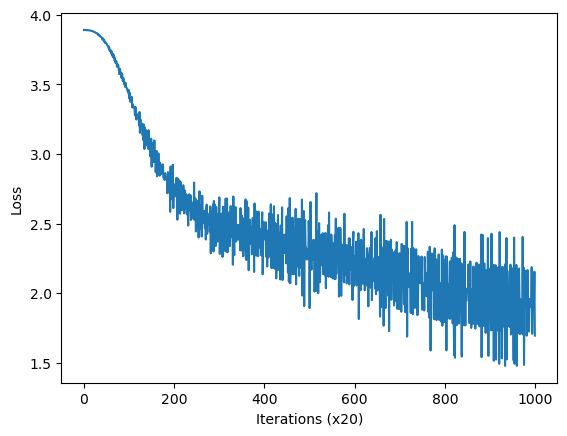

In [31]:
trainer.plot()

### 3.5.3 통계 기반 vs. 추론 기반

통계 기반 기법은 말뭉치의 전체 통계로부터 1회 학습해서 단어의 분산 표현을 얻는다.

추론 기반 기법에서는 말뭉치를 일부분씩 어러번 보면서 학습했다.

어휘에 추가할 새 단어가 생겨서 단어의 분산 표현을 갱신하려면,
- 통계 기반 기법 : 처음부터 다시 계산해야 한다.
- 추론 기반 기법 : 기존에 학습한 가중치를 초기값으로 사용해 다시 학습하면 된다.

따라서, 갱신에 대해서는 추론 기반 기법이 우세하다.

단어의 분산 표현의 성격이나 정밀도 면에서는,
- 통계 기반 기법 : 주로 단어의 유사성이 인코딩된다.
- 추론 기반 기법 : 단어의 유사성과 단어사이의 패턴까지 파악되어 인코딩된다.

이를 통해, 추론 기반 기법이 정확할 것 처럼 예상되지만 실제 평가 해 본 결과 우열을 가릴 수 없었다.

추론 기반 기법과 통계 기반 기법을 융합한 GloVe 기법이 있으며 이 기법은 말뭉치 전체의 통계 정보를 손실 함수에 도입해서 미니배치 학습을 수행한다.